In [436]:
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, explained_variance_score
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor
import cellbell


np.set_printoptions(precision=4)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from xgboost import XGBRegressor,XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [437]:
#All
all_plays = pd.read_csv('/Users/ianbury/Downloads/chckpt1.csv')
all_plays = all_plays[all_plays.season_year >= 2013]
print(len(all_plays))
print(all_plays.player_id.nunique())
print(all_plays.season_year.unique())

83760
3476
[2016 2017 2013 2014 2015]


In [548]:
#Plays from top 25 players only
df = pd.read_csv('/Users/ianbury/Downloads/top_plays_data.csv')
print(len(df))
print(df.player_id.nunique())
print(df.season_year.unique())

6765
209
[2017 2016 2015 2014 2013]


In [549]:
df.drop(columns=['change_vs_last','Unnamed: 0'],axis=1,inplace=True)
#Filtering to only offensive positions
pos=['QB','WR','RB','TE']
df=df[df.position.isin(pos)]

#Dropping non-predictive columns
df_clean = df.drop(columns=['gsis_id','name_fixed','years_pro','height','weight','forecast','home_score','away_score','season_type','desc','city','name','team_id','Year','Week','home','fumbles_rec_tds',
       'fumbles_lost', 'passing_int', 'passing_yds', 'passing_tds',
       'passing_twoptm', 'receiving_rec', 'receiving_tds', 'receiving_twoptm',
       'receiving_yds', 'rushing_yds', 'rushing_tds', 'rushing_twoptm',
       'kicking_rec_tds', 'puntret_tds', 'receiving_tar', 'rushing_att',
       'passing_att'])

In [550]:
def score_to_range(x):
    if x >= 30:
        return '30+'
    elif x >= 25:
        return '25-30'
    elif x >= 20:
        return '20-25'
    elif x >= 15:
        return '15-20'
    elif x >= 10:
        return '10-15'
    elif x >= 5:
        return '5-10'
    else:
        return '0-5'

In [551]:
df_clean['score_range'] = df_clean.fantasy_score.apply(score_to_range)

In [552]:
def is_home(df):
    if df['home_team'] == df['team']:
        return 1
    else:
        return 0
df_clean['is_home'] = df_clean.apply(is_home, axis=1)


In [553]:
def opponent(df):
    if df['home_team'] == df['team']:
        return df['away_team']
    else:
        return df['home_team']
df_clean['opponent'] = df_clean.apply(opponent, axis=1)
df_clean.drop('away_team',inplace=True,axis=1)
df_clean.drop('home_team',inplace=True,axis=1)

In [554]:
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['start_date'] = df_clean['start_time'].dt.date
df_clean['start_time'] = df_clean['start_time'].dt.time
df_clean.drop('start_date',inplace=True,axis=1)

In [555]:
df_players = df_clean.copy()
df_clean = pd.get_dummies(df_clean,columns=['start_time','position','day_of_week','desc_simple','team','opponent'])
df_clean.fillna('0',inplace=True)

In [556]:
#Creating train/test sets
df_players = pd.get_dummies(df_players,columns=['start_time','position','day_of_week','desc_simple','team','opponent','player_id'])
df_players.fillna('0',inplace=True)
X=df_clean.drop(['fantasy_score','score_range','player_id','season_year'],axis=1)


X_players=df_players.drop(['fantasy_score','score_range','season_year'],axis=1)
y_reg=df_clean.fantasy_score.values.reshape(-1,1)
y_clf=df_clean.score_range.values.reshape(-1,1)




clf_X_train, clf_X_test, clf_y_train, clf_y_test = train_test_split(X,y_clf,test_size=0.25, random_state=47)
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(X,y_reg,test_size=0.25, random_state=47)

# Regression

In [557]:
# Determine n_components for PCA
scores=[]
for n in range(1,117):
    s=StandardScaler()
    pca=PCA(n_components=n)
    km = Ridge(normalize=True)
    pl = Pipeline([('scaler',s),('pca',pca)
               ,('clf',km)])
    pl.fit(reg_X_train,reg_y_train.ravel())
    cv_results = cross_val_score(pl,reg_X_train,reg_y_train.ravel(),cv=5)
    scores.append(np.mean(cv_results))

n_components: 105


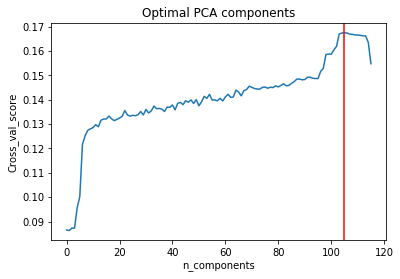

In [558]:
_=plt.plot(scores)
_=plt.xlabel('n_components')
_=plt.ylabel('Cross_val_score')
_=plt.title('Optimal PCA components')
_=plt.axvline(scores.index(max(scores)),c='red')
print('n_components: '+str(scores.index(max(scores))))

In [593]:
#Ridge Regression 
alphas = [0.01,0.1,1,10]
param_grid = {'clf__alpha':alphas}


s=StandardScaler()
pca=PCA(n_components=105)
clf = Ridge(normalize=True)
pl = Pipeline([('scaler',s),('pca',pca),('clf',clf)])
gs = GridSearchCV(pl,param_grid,cv=5)
gs.fit(reg_X_train,reg_y_train)
y_pred = gs.predict(reg_X_test)
mse_ridge = mean_squared_error(reg_y_test,y_pred)
print('MSE: '+str(mse_ridge))
print(gs.best_params_)
print(explained_variance_score(reg_y_test,y_pred))

MSE: 54.60258541898207
{'clf__alpha': 0.1}
0.22068976315062805


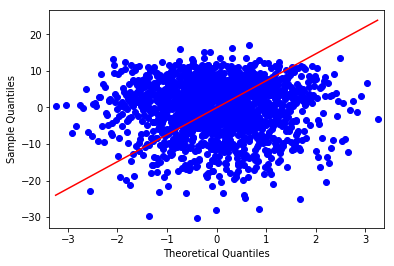

In [594]:
res = y_pred - reg_y_test
sm.qqplot(res,line='s')
plt.show()
# No clear pattern

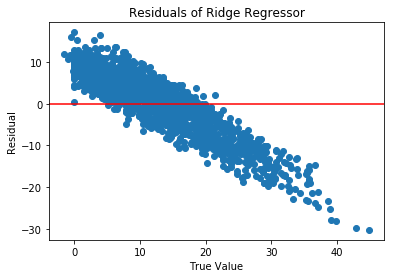

In [615]:
_=plt.scatter(reg_y_test,res)
_=plt.axhline(0,c='r')
_=plt.xlabel('True Value')
_=plt.ylabel('Residual')
_=plt.title('Residuals of Ridge Regressor')

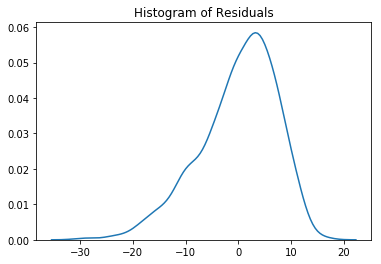

In [613]:
_=sns.distplot(res,kde=True,norm_hist=True,hist=False)
_=plt.title('Histogram of Residuals')

In [58]:
#SVM Pipeline
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'clf__C': Cs, 'clf__gamma' : gammas}

s=StandardScaler()
pca=PCA(n_components=105)
clf = SVR()

pl = Pipeline([('scaler',s),('pca',pca),('clf',clf)])
gs_svm = GridSearchCV(pl,param_grid, cv=5)
gs_svm.fit(reg_X_train,reg_y_train.ravel())


y_pred = gs_svm.predict(reg_X_test)
mse_svm = mean_squared_error(reg_y_test.ravel(),y_pred)
print('MSE: '+str(mse_svm))
print(gs_svm.best_params_)

MSE: 55.322428912168164
{'clf__C': 10, 'clf__gamma': 0.001}


In [75]:
def reg_pipeline(clf, X_train, y_train, X_test, y_test, param_grid):
    s=StandardScaler()
    pca=PCA(n_components=104)
    pl = Pipeline([('scaler',s),('pca',pca),('clf',clf)])
    gs = GridSearchCV(pl,param_grid, cv=5)
    gs.fit(X_train,y_train.ravel())
    y_pred = gs.predict(X_test)
    mse = mean_squared_error(y_test.ravel(),y_pred)
    return mse

In [391]:
#GradientBoostingRegressor
alphas = [0.01,0.1,0.9]
param_grid = {'clf__alpha':alphas}

s=StandardScaler()
pca=PCA(n_components=105)
clf = GradientBoostingRegressor()

pl = Pipeline([('scaler',s),('pca',pca),('clf',clf)])
gs_gbr = GridSearchCV(pl,param_grid, cv=5)
gs_gbr.fit(reg_X_train,reg_y_train.ravel())


y_pred = gs_gbr.predict(reg_X_test)
mse_gbr = mean_squared_error(reg_y_test.ravel(),y_pred)
mse_gbr

56.38338896059015

0.3849012499436709

0.19523616551104273

In [400]:
#XGBoost
gammas = [0.001, 0.01, 0.1, 1]
alphas = [0.01,0.1,1,10]

xgb = XGBRegressor()

pg={'clf__gamma' : gammas,
    'clf__reg_alpha':alphas}
  
mse_xgb= reg_pipeline(xgb, reg_X_train,reg_y_train,reg_X_test,reg_y_test,pg)

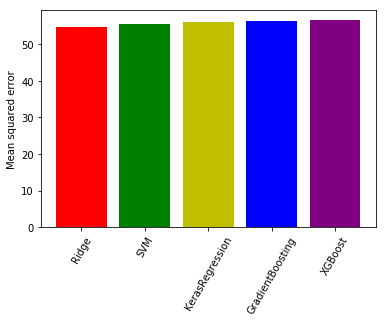

In [430]:
y=np.array([mse_ridge,mse_svm,mse_nn,mse_gbr,mse_xgb])

labels=['Ridge','SVM','KerasRegression','GradientBoosting','XGBoost']

x=np.linspace(0,1,len(y))
plt.bar(x,y,tick_label=labels,align='center',width=0.2, color=['r','g','y','b','purple'])
_=plt.xticks(rotation=60)
_=plt.ylabel('Mean squared error')
plt.show()

# Classification

In [103]:
def clf_pipeline(clf, X_train, y_train, X_test, y_test, param_grid):
    s=StandardScaler()
    pca=PCA(n_components=104)
    pl = Pipeline([('scaler',s),('pca',pca),('clf',clf)])
    gs = GridSearchCV(pl,param_grid, cv=5)
    gs.fit(X_train,y_train.ravel())
    y_pred = gs.predict(X_test)
    acc = accuracy_score(y_test.ravel(),y_pred)
    return acc

In [397]:
#XGBoost Classifier
param_grid = {'clf__gamma' : gammas,
              'clf__reg_alpha':alphas}
clf = XGBClassifier()
acc_xgb=clf_pipeline(clf,clf_X_train,clf_y_train,clf_X_test,clf_y_test,param_grid)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [ ]:
print('done')
%ding

In [399]:
#RandomForest Param Grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'clf__n_estimators': n_estimators,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf}



#RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
acc_rf=clf_pipeline(rf,clf_X_train,clf_y_train,clf_X_test,clf_y_test,random_grid)
acc_rf


0.29432624113475175

{'clf__alpha': 0.1}

In [564]:
#LogisticRegression
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'clf__C': Cs}
log=  LogisticRegression()
acc_lr=clf_pipeline(log,clf_X_train,clf_y_train,clf_X_test,clf_y_test,param_grid)
acc_lr

0.31619385342789597

In [565]:
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'clf__C': Cs}
s=StandardScaler()
pca=PCA(n_components=105)
pl = Pipeline([('scaler',s),('pca',pca),('clf',log)])
gs = GridSearchCV(pl,param_grid, cv=5)
gs.fit(clf_X_train,clf_y_train.ravel())
y_pred = gs.predict(clf_X_test)

In [566]:
c = clf_X_test.copy()
c['true_class'] = clf_y_test
c['pred']  =y_pred

In [569]:
def from_dummies(data, categories, prefix_sep='_'):
    out = data.copy()
    for l in categories:
        cols, labs = [[c.replace(x,"") for c in data.columns if l+prefix_sep in c] for x in ["", l+prefix_sep]]
        out[l] = pd.Categorical(np.array(labs)[np.argmax(data[cols].values, axis=1)])
        out.drop(cols, axis=1, inplace=True)
    return out

In [570]:

c = from_dummies(c, categories=['start_time','position','day_of_week','desc_simple','team','opponent'])

In [571]:
c['correct']=c.apply(lambda x:1 if x['true_class']==x['pred'] else 0,axis=1)

In [572]:
c.columns

Index(['week', 'temp', 'prev_score', 'avg3_score', 'avg5_score', 'avg3_tar',
       'avg5_tar', 'avg3_rush_att', 'avg5_rush_att', 'prev_tar',
       'prev_rush_att', 'prev_pass_att', 'avg3_pass_att', 'avg5_pass_att',
       'is_home', 'true_class', 'pred', 'start_time', 'position',
       'day_of_week', 'desc_simple', 'team', 'opponent', 'correct'],
      dtype='object')

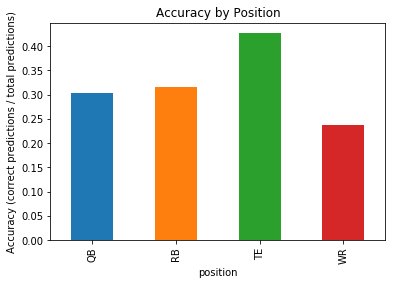

In [573]:
c.groupby(['position']).correct.mean().plot(kind='bar')
_=plt.title('Accuracy by Position')
_=plt.ylabel('Accuracy (correct predictions / total predictions)')

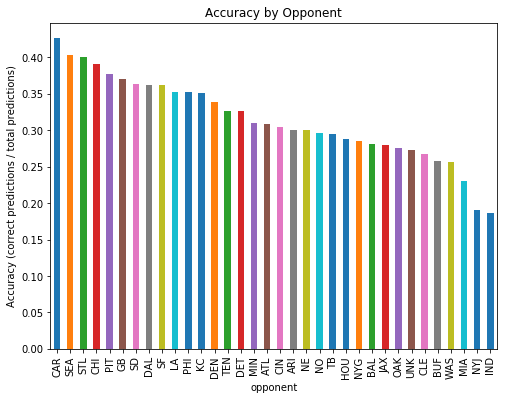

In [581]:
fig = plt.figure(figsize=(8,6))
c.groupby(['opponent']).correct.mean().sort_values(ascending=False).plot(kind='bar')
_=plt.title('Accuracy by Opponent')
_=plt.ylabel('Accuracy (correct predictions / total predictions)')

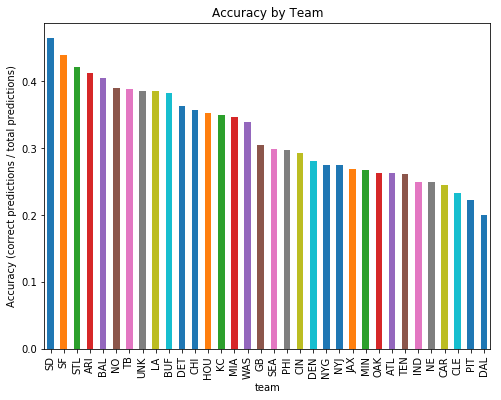

In [582]:
fig = plt.figure(figsize=(8,6))
c.groupby(['team']).correct.mean().sort_values(ascending=False).plot(kind='bar')
_=plt.title('Accuracy by Team')
_=plt.ylabel('Accuracy (correct predictions / total predictions)')

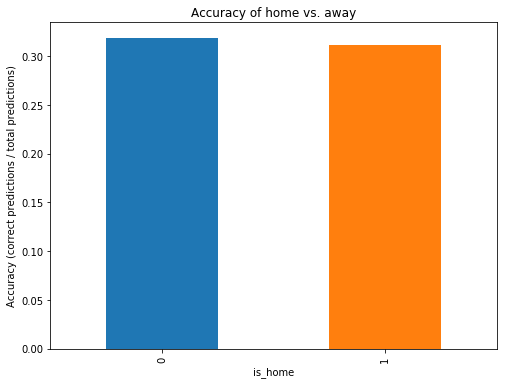

In [584]:
fig = plt.figure(figsize=(8,6))
c.groupby(['is_home']).correct.mean().sort_values(ascending=False).plot(kind='bar')
_=plt.title('Accuracy of home vs. away')
_=plt.ylabel('Accuracy (correct predictions / total predictions)')

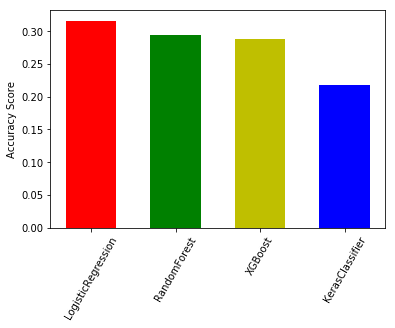

In [575]:
labels=['LogisticRegression','RandomForest','XGBoost','KerasClassifier']
y=np.array([acc_lr,acc_rf,acc_xgb,acc_nn])
x=np.linspace(0,1,len(y))
plt.bar(x,y,tick_label=labels,align='center',width=0.2, color=['r','g','y','b'])
_=plt.xticks(rotation=60)
_=plt.ylabel('Accuracy Score')
plt.show()

# Neural Net - Regression

In [262]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(75, input_dim=105, kernel_initializer='normal', activation='relu'))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [263]:
# fix random seed for reproducibility

p_grid={
       'mlp__epochs':[1,2,5,7,10],
       'mlp__batch_size':[10, 20, 40, 60, 80, 100]
        }


seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('pca', PCA(n_components=105)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, verbose=0)))
pipeline = Pipeline(estimators)
rs = RandomizedSearchCV(pipeline,p_grid, cv=5,verbose=10)


In [264]:
rs.fit(reg_X_train,reg_y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=5, mlp__batch_size=10, score=-54.0394461871368, total=  10.3s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=-59.00403862751176, total=  10.7s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=-48.52170959247157, total=  11.0s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=-53.11716368823832, total=  10.9s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.1s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=-61.78795032200259, total=  10.7s
[CV] mlp__epochs=5, mlp__batch_size=60 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.7s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=60, score=-52.76197469175743, total=   6.2s
[CV] mlp__epochs=5, mlp__batch_size=60 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=60, score=-58.71068635010367, total=   6.2s
[CV] mlp__epochs=5, mlp__batch_size=60 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=60, score=-48.15698277891563, total=   6.3s
[CV] mlp__epochs=5, mlp__batch_size=60 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=60, score=-51.699582342565414, total=   6.2s
[CV] mlp__epochs=5, mlp__batch_size=60 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=60, score=-59.425864992762456, total=   6.2s
[CV] mlp__epochs=2, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=2, mlp__batch_size=10, score=-52.6953661876359, total=   7.7s
[CV] mlp__epochs=2, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=2, mlp__batch_size=10, score=-60.45817313170785, total=   7.8s
[CV] mlp__epochs=2, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=2, mlp__batch_size=10, score=-49.0123250801575, total=   7.9s
[CV] mlp__epochs=2, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=2, mlp__batch_size=10, score=-52.94346992974216, total=   7.9s
[CV] mlp__epochs=2, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=2, mlp__batch_size=10, score=-59.43380272506022, total=   7.9s
[CV] mlp__epochs=10, mlp__batch_size=20 ..............................
[CV]  mlp__epochs=10, mlp__batch_size=20, score=-54.12371711543041, total=  12.0s
[CV] ml

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=105, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x1c9fb86940>)]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'mlp__epochs': [1, 2, 5, 7, 10], 'mlp__batch_size': [10, 20, 40, 60, 80, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [265]:
rs.best_params_

{'mlp__epochs': 5, 'mlp__batch_size': 60}

In [266]:
y_pred = rs.predict(reg_X_test)


In [267]:
mse_nn = mean_squared_error(reg_y_test,y_pred)
mse_nn

55.84873676252868

# Neural Net - Classification

In [271]:

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(clf_y_train.ravel())
encoded_Y = encoder.transform(clf_y_train.ravel())
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [285]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(105, input_dim=105,kernel_initializer='normal', activation='relu'))
    model.add(Dense(50,kernel_initializer='normal', activation='softmax'))
    model.add(Dense(7, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [294]:
p_grid={
       'mlp__epochs':[8,10,12],
       'mlp__batch_size':[60, 80, 100]
        }


seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('pca', PCA(n_components=105)))
estimators.append(('mlp', KerasClassifier(build_fn=baseline_model, verbose=0)))
pipeline = Pipeline(estimators)
rs = RandomizedSearchCV(pipeline,p_grid, cv=5,verbose=10)


In [288]:
rs.fit(clf_X_train,dummy_y)
y_pred=rs.predict(clf_X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................
[CV]  mlp__epochs=5, mlp__batch_size=10, score=0.22561576830342486, total=  22.5s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.2s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=0.2019704473870141, total=  22.5s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.3s remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=0.21477832942467018, total=  22.5s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=0.22781065536967865, total=  22.8s
[CV] mlp__epochs=5, mlp__batch_size=10 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV]  mlp__epochs=5, mlp__batch_size=10, score=0.21104536950588226, total=  22.9s
[CV] mlp__epochs=2, mlp__batch_size=100 ..............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


[CV]  mlp__epochs=2, mlp__batch_size=100, score=0.1704433484764522, total=  11.4s
[CV] mlp__epochs=2, mlp__batch_size=100 ..............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


[CV]  mlp__epochs=2, mlp__batch_size=100, score=0.21970443530329342, total=  11.4s
[CV] mlp__epochs=2, mlp__batch_size=100 ..............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


[CV]  mlp__epochs=2, mlp__batch_size=100, score=0.15862069011028176, total=  11.7s
[CV] mlp__epochs=2, mlp__batch_size=100 ..............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s


[CV]  mlp__epochs=2, mlp__batch_size=100, score=0.2209072978009839, total=  11.5s
[CV] mlp__epochs=2, mlp__batch_size=100 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s


[CV]  mlp__epochs=2, mlp__batch_size=100, score=0.14595660767141413, total=  11.5s
[CV] mlp__epochs=1, mlp__batch_size=80 ...............................
[CV]  mlp__epochs=1, mlp__batch_size=80, score=0.1980295576191888, total=  11.5s
[CV] mlp__epochs=1, mlp__batch_size=80 ...............................
[CV]  mlp__epochs=1, mlp__batch_size=80, score=0.1812807866211595, total=  11.4s
[CV] mlp__epochs=1, mlp__batch_size=80 ...............................
[CV]  mlp__epochs=1, mlp__batch_size=80, score=0.2098522161321687, total=  11.5s
[CV] mlp__epochs=1, mlp__batch_size=80 ...............................
[CV]  mlp__epochs=1, mlp__batch_size=80, score=0.1715976319310698, total=  11.7s
[CV] mlp__epochs=1, mlp__batch_size=80 ...............................
[CV]  mlp__epochs=1, mlp__batch_size=80, score=0.19921104492402877, total=  11.7s
[CV] mlp__epochs=7, mlp__batch_size=60 ...............................
[CV]  mlp__epochs=7, mlp__batch_size=60, score=0.18620689998706574, total=  14.5s
[CV

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.4min finished


In [297]:
encoded_y_test = encoder.transform(clf_y_test.ravel())


In [307]:
acc_nn = accuracy_score(encoded_y_test,y_pred)
acc_nn

0.21749408983451538

# Per-player predictions

In [342]:
p_clf_X_train, p_clf_X_test, p_clf_y_train, p_clf_y_test = train_test_split(X_players,y_clf,test_size=0.25, random_state=47)
p_reg_X_train, p_reg_X_test, p_reg_y_train, p_reg_y_test = train_test_split(X_players,y_reg,test_size=0.25, random_state=47)

In [353]:
# Determine n_components for PCA
scores=[]
for n in range(1,325):
    s=StandardScaler()
    pca=PCA(n_components=n)
    km = Ridge(normalize=True)
    pl = Pipeline([('scaler',s),('pca',pca)
               ,('clf',km)])
    pl.fit(p_reg_X_train,p_reg_y_train.ravel())
    cv_results = cross_val_score(pl,p_reg_X_train,p_reg_y_train.ravel(),cv=5)
    scores.append(np.mean(cv_results))

n_components: 288


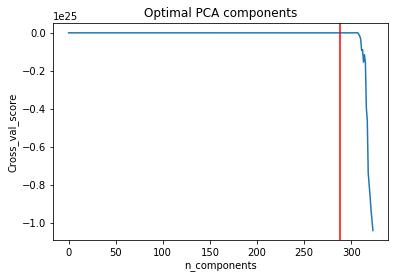

In [354]:
_=plt.plot(scores)
_=plt.xlabel('n_components')
_=plt.ylabel('Cross_val_score')
_=plt.title('Optimal PCA components')
_=plt.axvline(scores.index(max(scores)),c='red')
print('n_components: '+str(scores.index(max(scores))))

In [376]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(75, input_dim=275, kernel_initializer='normal', activation='relu'))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [381]:
# fix random seed for reproducibility

p_grid={
       'mlp__epochs':[2,5,10],
       'mlp__batch_size':[10, 20, 40, 60, 80, 100]
        }


seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('pca', PCA(n_components=275)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model,verbose=10)))
pipeline = Pipeline(estimators)
rs = RandomizedSearchCV(pipeline,p_grid, cv=5,verbose=10)

In [382]:
rs.fit(p_reg_X_train,p_reg_y_train)
y_pred = rs.predict(p_reg_X_test)
mse_nn = mean_squared_error(p_reg_y_test,y_pred)
mse_nn

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] mlp__epochs=10, mlp__batch_size=80 ..............................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=80, score=-54.16231472973753, total=  27.7s
[CV] mlp__epochs=10, mlp__batch_size=80 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=80, score=-58.35355644038158, total=  27.9s
[CV] mlp__epochs=10, mlp__batch_size=80 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.9s remaining:    0.0s


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=80, score=-52.66516117039573, total=  28.2s
[CV] mlp__epochs=10, mlp__batch_size=80 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=80, score=-52.18258860360471, total=  28.4s
[CV] mlp__epochs=10, mlp__batch_size=80 ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=80, score=-57.57083944738264, total=  28.2s
[CV] mlp__epochs=2, mlp__batch_size=80 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  mlp__epochs=2, mlp__batch_size=80, score=-53.40527941323266, total=  23.4s
[CV] mlp__epochs=2, mlp__batch_size=80 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  mlp__epochs=2, mlp__batch_size=80, score=-56.49412068709951, total=  23.4s
[CV] mlp__epochs=2, mlp__batch_size=80 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.2min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  mlp__epochs=2, mlp__batch_size=80, score=-49.3370197277351, total=  23.4s
[CV] mlp__epochs=2, mlp__batch_size=80 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  mlp__epochs=2, mlp__batch_size=80, score=-51.707998113989596, total=  23.9s
[CV] mlp__epochs=2, mlp__batch_size=80 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  mlp__epochs=2, mlp__batch_size=80, score=-57.575105588111654, total=  23.7s
[CV] mlp__epochs=5, mlp__batch_size=100 ..............................
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  mlp__epochs=5, mlp__batch_size=100, score=-53.43678798581579, total=  25.2s
[CV] mlp__epochs=5, mlp__batch_size=100 ..............................
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  mlp__epochs=5, mlp__batch_size=100, score=-57.48884372053475, total=  25.3s
[CV] mlp__epochs=5, mlp__batch_size=100 ..............................
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  mlp__epochs=5, mlp__batch_size=100, score=-47.63725257272203, total=  25.8s
[CV] mlp__epochs=5, mlp__batch_size=100 ..............................
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  mlp__epochs=5, mlp__batch_size=100, score=-51.65623304077389, total=  26.6s
[CV] mlp__epochs=5, mlp__batch_size=100 ..............................
Epoch 1/5
Epoch

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=100, score=-57.716952676256305, total=  24.4s
[CV] mlp__epochs=10, mlp__batch_size=100 .............................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=100, score=-48.461329878257416, total=  25.4s
[CV] mlp__epochs=10, mlp__batch_size=100 .............................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=100, score=-52.16354931411894, total=  24.7s
[CV] mlp__epochs=10, mlp__batch_size=100 .............................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  mlp__epochs=10, mlp__batch_size=100, score=-57.58391223809658, total=  25.4s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 29.8min finished


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


55.88924694392959

In [383]:
rs.best_params_

{'mlp__epochs': 5, 'mlp__batch_size': 100}